<a href="https://colab.research.google.com/github/Dim0000n/Variational-Autoencoder-MNIST/blob/main/CVAE_for_MNIST_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras.layers import Input, Flatten,Dense,Dropout,BatchNormalization,Reshape,concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback

from keras.datasets import mnist
from keras import utils

#Uploading and preprocessing

In [2]:

(xTrain,yTrain),(xTest,yTest)=mnist.load_data()

xTrain=xTrain.astype("float32")/255.
xTest=xTest.astype("float32")/255.
xTrain=np.reshape(xTrain,(len(xTrain),28,28,1))
xTest=np.reshape(xTest,(len(xTest),28,28,1))

yTrain=utils.to_categorical(yTrain).astype(np.float32)
yTest=utils.to_categorical(yTest).astype(np.float32)
num_classes=yTest.shape[1]

11493376/11490434 [==============================] - 0s 0us/step


#Classes Smpling and Vae

In [3]:
#Creating Sampling layer
class Sampling(layers.Layer):

  def call(self,inputs):
    z_mean,z_log_var=inputs
    batch=tf.shape(z_mean)[0]  
    dim=tf.shape(z_mean)[1]
    epsilon=tf.keras.backend.random_normal(shape=(batch,dim)) 
    
    return z_mean+tf.exp(0.5*z_log_var)*epsilon  

In [4]:
#Creating Model class 
class VAE(keras.Model):
    #initializing
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder 
        self.decoder = decoder 
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.total_val_loss_tracker = keras.metrics.Mean(name="val_total_loss")

    @property
    def metrics(self): 
        return [
            self.total_loss_tracker,
            self.total_val_loss_tracker
        ]

    def train_step(self, data): #Train step definition
        with tf.GradientTape() as tape:
            
            self.data1=data
            z_mean, z_log_var, z = self.encoder(data) 
            reconstruction = self.decoder([z,data[0][1]]) 
            reconstruction_loss = tf.reduce_mean(  
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data[0][0], reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) 
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))  
            total_loss = (reconstruction_loss + kl_loss)/2/28/28 

        grads = tape.gradient(total_loss, self.trainable_weights) 
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) 
        
        self.total_loss_tracker.update_state(total_loss)
        return {
            
            "loss": self.total_loss_tracker.result(),
            
        }
       #Test-step definition 
    def test_step(self, data):
      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder([z,data[0][1]]) 
      reconstruction_loss = tf.reduce_mean(  
        tf.reduce_sum(
                  keras.losses.binary_crossentropy(data[0][0], reconstruction), axis=(1, 2)
                )
            )
    
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) 
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1)) 
      val_loss = (reconstruction_loss + kl_loss)/2/28/28 
      self.total_val_loss_tracker.update_state(val_loss)
      return  {
          "loss": self.total_val_loss_tracker.result(),
      }    



#Сети

In [5]:
#Parametrs initialization
latent_dim=8 #Shape of latent dimention
dropout_rate=0.3 
start_lr=1e-3

##Callback

In [6]:

save_epochs=[i*5 for i in range(0,25)]  #Epoch-numbers for images drawing 

n_compare=10  #number of images

def on_epoch_end(epoch,logs):   #callback
  if epoch in save_epochs:
    clear_output()
    _,_,encoded=encoder.predict([xTest[:n_compare],yTest[:n_compare]]) 
    decoded=decoder.predict([encoded,yTest[:n_compare]])  
    plot_digits(xTest[:n_compare],decoded) #drawing images

pltFig=LambdaCallback(on_epoch_end=on_epoch_end)

In [14]:
digit_size=28 #digit size

#Image drawing function
def plot_digits(*args,invert_colors=False):
  args=[x.squeeze() for x in args]
  n=min([x.shape[0] for x in args ])

  figure=np.zeros((digit_size*len(args),digit_size*n))

  for i in range(n):
    for j in range(len(args)):
      figure[j*digit_size:(j+1)*digit_size,i*digit_size:(i+1)*digit_size]=args[j][i].squeeze()

  if invert_colors:
    figure=1-figure

  plt.figure(figsize=(2*n,2*len(args)))
  plt.imshow(figure,cmap="Greys_r")
  plt.grid(False)
  ax=plt.gca()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()    

## sipmle-CVAE without Dropout

In [15]:


#encoder creation

encoder_img=Input(shape=(28,28,1)) #Image input
flatten_img=Flatten()(encoder_img)
encoder_lb=Input(shape=(num_classes,),dtype="float32") #Label input

x=concatenate([flatten_img,encoder_lb]) 

x=Dense(64,activation="relu")(x)

# layers z_mean and  z_log_var
z_mean=Dense(latent_dim,name="z_mean")(x)
z_log_var=layers.Dense(latent_dim,name="z_log_var")(x)

#Sampling-layer
z=Sampling()([z_mean,z_log_var])

encoder=Model([encoder_img,encoder_lb],[z_mean, z_log_var,z],name="encoder")

In [16]:
#decoder creation
decoder_vector=Input(shape=(latent_dim,))  #encoded image vector
decoder_lb=Input(shape=(num_classes,),dtype="float32") #label

x=concatenate([decoder_vector,decoder_lb]) #объединение выходов

x=Dense(64)(x)
x=LeakyReLU()(x)

x=Dense(28*28,activation="sigmoid")(x)
decoder_outputs=Reshape((28,28,1))(x)

decoder=Model([decoder_vector,decoder_lb],decoder_outputs,name="decoder")


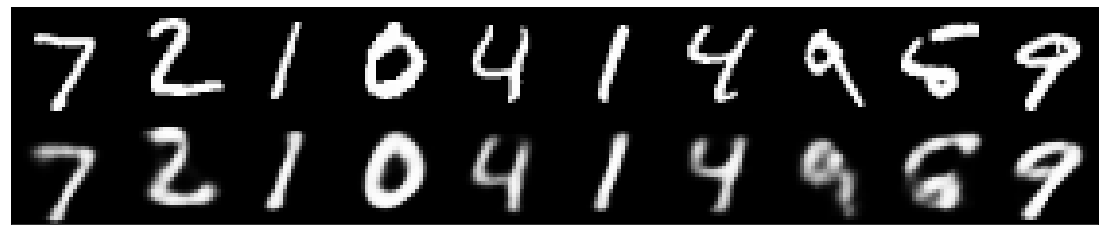

Epoch 27/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0736 - val_loss: 0.0731
Epoch 28/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0736 - val_loss: 0.0730
Epoch 29/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0735 - val_loss: 0.0729
Epoch 30/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0735 - val_loss: 0.0728


In [17]:
scvae=VAE(encoder,decoder) #Создадим объект
scvae.compile(optimizer=Adam(lr=start_lr)) #компиляция
shistory=scvae.fit([xTrain,yTrain],epochs=30, batch_size=128,validation_data=([xTest,yTest]),callbacks=[pltFig]) #обучение 

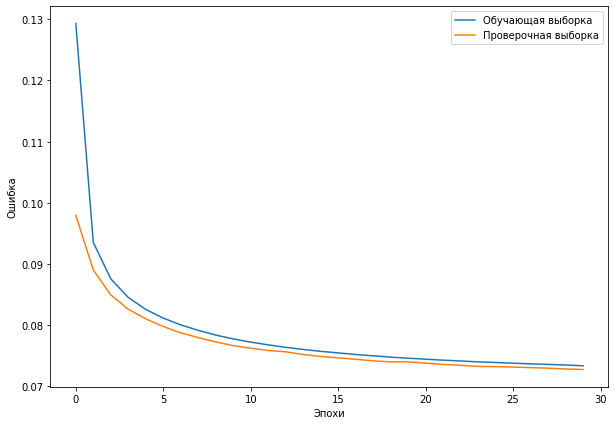

In [18]:
plt.figure(figsize=(10,7))
plt.plot(shistory.history["loss"],label="Обучающая выборка")
plt.plot(shistory.history["val_loss"],label="Проверочная выборка")
plt.xlabel("Эпохи")
plt.ylabel("Ошибка")
plt.legend()
plt.show()

##complex-CVAE with dropout

In [23]:


#encoder creation

encoder_img=Input(shape=(28,28,1)) #image input
flatten_img=Flatten()(encoder_img)
encoder_lb=Input(shape=(num_classes,),dtype="float32") #label input

x=concatenate([flatten_img,encoder_lb]) #слой объединения

x=Dense(256,activation="relu")(x)
x=Dropout(dropout_rate)(x)
x=Dense(128,activation="relu")(x)
x=Dropout(dropout_rate)(x)

#  z_mean and  z_log_var
z_mean=Dense(latent_dim,name="z_mean")(x)
z_log_var=layers.Dense(latent_dim,name="z_log_var")(x)

# Smpling
z=Sampling()([z_mean,z_log_var])

encoder=Model([encoder_img,encoder_lb],[z_mean, z_log_var,z],name="encoder")


In [24]:
#decoder creation
decoder_vector=Input(shape=(latent_dim,))  #encoded image 
decoder_lb=Input(shape=(num_classes,),dtype="float32") #label

x=concatenate([decoder_vector,decoder_lb]) 
x=Dense(256)(x)
x=LeakyReLU()(x)
x=Dense(128)(x)
x=LeakyReLU()(x)
x=Dropout(dropout_rate)(x)
x=Dense(28*28,activation="sigmoid")(x)
decoder_outputs=Reshape((28,28,1))(x)

decoder=Model([decoder_vector,decoder_lb],decoder_outputs,name="decoder")



In [25]:
cvae=VAE(encoder,decoder) #Object 

In [26]:
cvae.compile(optimizer=Adam(lr=start_lr)) 

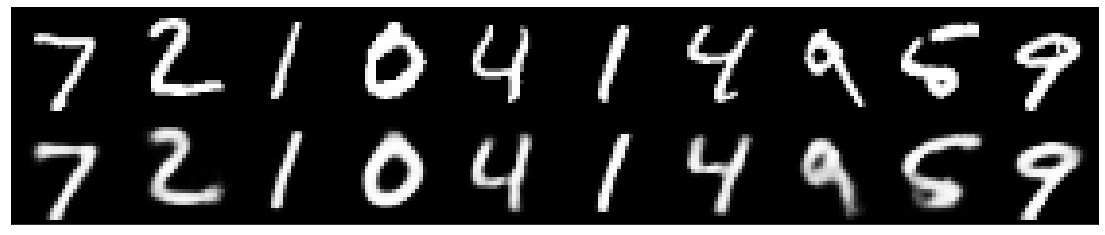

Epoch 57/60
469/469 [==============================] - 2s 5ms/step - loss: 0.0636 - val_loss: 0.0640
Epoch 58/60
469/469 [==============================] - 3s 5ms/step - loss: 0.0635 - val_loss: 0.0640
Epoch 59/60
469/469 [==============================] - 2s 5ms/step - loss: 0.0635 - val_loss: 0.0638
Epoch 60/60
469/469 [==============================] - 2s 5ms/step - loss: 0.0635 - val_loss: 0.0638


In [27]:
history=cvae.fit([xTrain,yTrain],epochs=60, batch_size=128,validation_data=([xTest,yTest]),callbacks=[pltFig]) #training

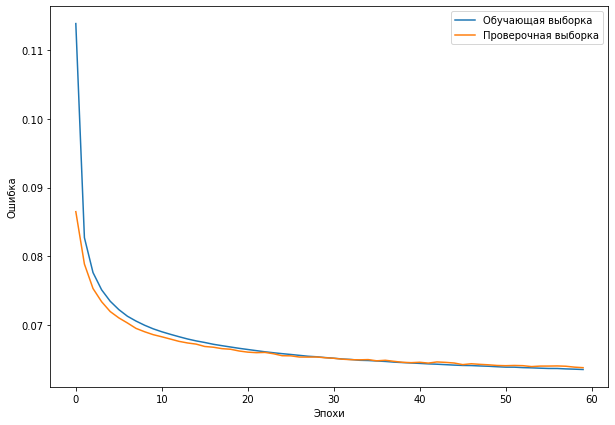

In [28]:
plt.figure(figsize=(10,7))
plt.plot(history.history["loss"],label="Обучающая выборка")
plt.plot(history.history["val_loss"],label="Проверочная выборка")
plt.xlabel("Эпохи")
plt.ylabel("Ошибка")
plt.legend()
plt.show()

##Сравнение результатов

In [20]:
def plotSingleImage(generator,label):
  noise=np.random.normal(loc=0,scale=1,size=[1,latent_dim]).reshape(1,latent_dim,1)
  lb=np.zeros((1,10,1))
  lb[0,label]=1
  pred=generator.predict([noise,lb])
  plt.imshow(pred.reshape(28,28))

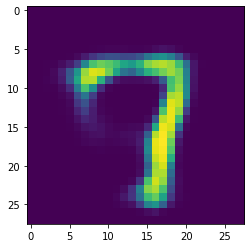

In [30]:
plotSingleImage(scvae.decoder,7) #simple network

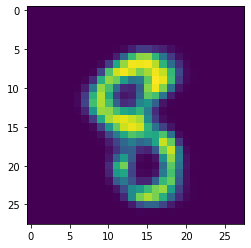

In [36]:
plotSingleImage(cvae.decoder,8) # with dropout

#Digits generation

In [44]:
#generation of different digits from one normal noise vector
rand=np.random.normal(loc=0,scale=1,size=[1,latent_dim])

def draw_digit(label):
  lb=np.zeros((1,10,1))
  lb[0,label]=1
  pred=decoder.predict([rand,lb])
  plt.imshow(pred.reshape(28,28))
  plt.show()

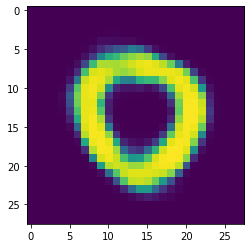

In [45]:
draw_digit(0)

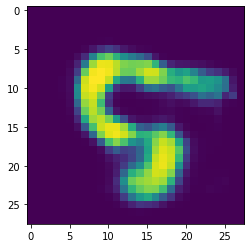

In [46]:
draw_digit(5)

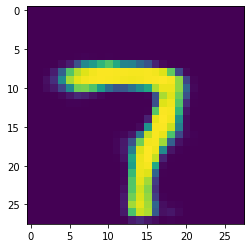

In [47]:
draw_digit(7)

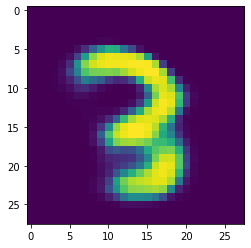

In [48]:
draw_digit(3)

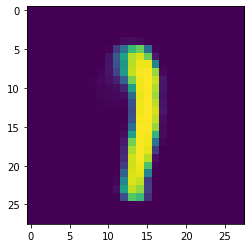

In [49]:
draw_digit(1)